At the most basic level, data analysis is really about trying to understand a process and to make rational predictions based off of data.  Sometimes you have to compromise and can only accomplish the latter but when we fit data we can try to achieve both of these goals.

# __Histograms as an Estimate of the PDF__

Like I mentioned last week, unbinned likelihood fitting is the preferred method but often times it is impractical.  Most times, we are forced to bin data for storage and/or computation reasons.  Also, sometimes we don't have an analytical description, which is absolutely necessary for an unbinned fit.

So first we will need some data!  I'm going to simulate 200 heights from a normal distribution and we will bin this for our dataset.

In [11]:
import numpy as np
import scipy, scipy.stats

# keeps plots inside shell
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd

import statsmodels.api as sm

In [12]:
num_data_pts = 2000
height_data = np.random.normal(loc=177, scale=7, size=num_data_pts)

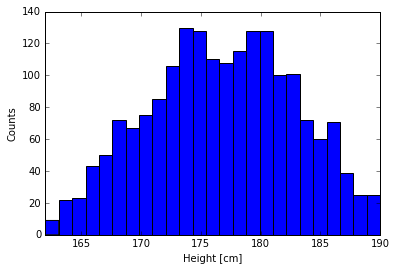

In [13]:
num_bins = 25
a_range = (162, 190)
y_values, bin_edges, _ = plt.hist(height_data, bins=num_bins, range=a_range)
_ = plt.xlim(a_range)
_ = plt.xlabel('Height [cm]')
_ = plt.ylabel('Counts')

Now we have the data, the bin edges, and the bin values but we will also need the bin centers.  Below we recap and find the bin centers.

In [14]:
# y_values: counts in bin (len=num_bins)
# bin_edges: edges of each bin (len=num_bins+1)
# x_values: bin centers (len=num_bins)
num_pts_in_range = np.sum(y_values) # count the number of points we include in the histogram
x_values = np.zeros(num_bins)
for i in xrange(num_bins):
    x_values[i] = (bin_edges[i]+bin_edges[i+1])/2.
    

Of course, if we repeat this experiment we don't expect to get exactly the same results so each bin can be thought of as its own probability distribution.

So let's think about this with respect to the distributions we learned about last week.  Let's pick a bin and ask ourselves, given the total number of events we have and the number of events in this bin, what does our distribution look like?

What if we say that we can approximate the probability that given an event it falls into a certain bin using the current number of counts in that bin?  In other words $$p_i \approx \frac{N_i}{\sum_i N_i}$$

So now we have a situation where we have a certain number of trials and we have an estimate of the "success" probability.  This should sound like the binomial distribution!

Now we can go a step further and make our lives a little easier.  Usually, we make histograms fine enough that no bin has a large portion of the events, say ~10%.  What does this information give us?

So going back to last week, if our number of trials is large, which it almost always should be for a histogram, and our probability of success is small, we can actually approximate the binomial distribution as a Poisson distribution!

Let's try it out:

Probability event is in bin 10: 0.069


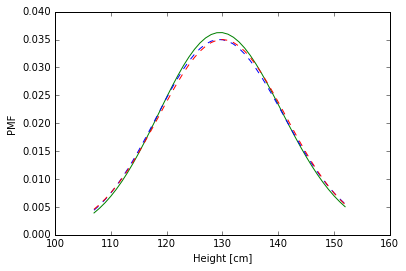

In [15]:
# we're going to look at the "worst" case where the probability is the largest
max_bin = np.argmax(y_values)
max_val = y_values[max_bin]

prob_event_goes_to_max_bin = max_val / float(num_pts_in_range)
print 'Probability event is in bin %d: %.3f' % (max_bin, prob_event_goes_to_max_bin)

# we need to make our range of values to look at
lb_range = int(max_val-2*max_val**0.5)
ub_range = int(max_val+2*max_val**0.5)
a_prob_range = np.linspace(lb_range, ub_range, ub_range-lb_range+1)

a_prob_binomial = scipy.stats.binom.pmf(a_prob_range, num_pts_in_range, prob_event_goes_to_max_bin)
# remember that the mean of the Poisson will just be
# the total number of events times the probability
# which by definition is just the number of events in that bin
a_prob_poisson = scipy.stats.poisson.pmf(a_prob_range, max_val)
a_probs_normal = scipy.stats.norm.pdf(a_prob_range, max_val, max_val**0.5)


_ = plt.plot(a_prob_range, a_prob_binomial, 'g-')
_ = plt.plot(a_prob_range, a_prob_poisson, 'b--')
_ = plt.plot(a_prob_range, a_probs_normal, 'r--')
_ = plt.xlabel('Height [cm]')
_ = plt.ylabel('PMF')

As you can see, the Poisson approximation is quite good!  I also jumped the gun a little bit and included the gaussian but as you can see, this is also a good approximation.

Since we now understand the PDF of each bin, we have effectively estimated the PDF of our data (once we normalize).  While typically we want to use a model since we're trying to understand the underlying process or reasoning behind the data, model-independent approaches can be very valuable since they give us predicitive power! 

# __Fitting Binned Data__

As I just mentioned, this model-independent approach using a histogram gave us some predicitive power but it really doesn't tell us much about the underlying distribution or the process.  Sometimes we don't need this information so it's fine but other times we really need this understanding (also, the histogram estimate is quite coarse and practically difficult to use).

One major example of this comes from detector calibrations.  Today I will focus on a very specific kind of detector called a photomultiplier tube, otherwise known as a PMT.  PMT's are very important because they can detect photons and produce an output signal proportional to the number of photons detected.  While the numbers I choose will be just for the sake of the example and won't be physical, the issue itself is very real and an important part of many experiments, including Xenon1T!

We're going to simplify the situation quite a bit so don't take this as an electronics lesson!

We will assume that our detector has a single PMT inside that produces a signal in mV everytime it sees light from an interaction in our detector.  Given that our detector at a basic level has some random processes involved, this means that when any number of photons strike we will have a PDF describing the output voltage.  Now since we know that the physical process is identical for different photons and that our PMT is **linear**, if we have two input photons at the same time our resulting PDF we simply be the **convolution** of two single photon signals.  By linearity, this is true for any number of photons - if you have n input photons, your PDF will be the convolution of n single photon signals.  Therefore, it is very important that we know the PDF of the single photon response very well and understand it!  Predictive power for a single photon is not enough!

We will make our lives easy and make the PDF of the single photon detection a gaussian although we could make our lives much more difficult if we wanted to!

Now let's pretend that in our detector, we have a way to make sure that our PMT always sees exactly one photon so we use this method to take the data below.

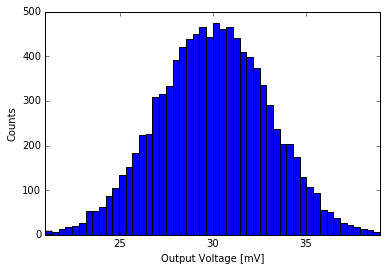

In [16]:
true_mean = 30 # mV
true_std = 3 # mV
num_pmt_pts = 10000
num_bins_pmt = 50
lb_range_pmt = true_mean-3*true_std
ub_range_pmt = true_mean+3*true_std

a_pmt_data = np.random.normal(true_mean, true_std, num_pmt_pts)

a_counts, bin_edges_pmt, _ = plt.hist(a_pmt_data, bins=num_bins_pmt, range=(lb_range_pmt, ub_range_pmt))
_ = plt.xlim((lb_range_pmt, ub_range_pmt))
_ = plt.xlabel('Output Voltage [mV]')
_ = plt.ylabel('Counts')

Now we have our data and in this case we **could** do an unbinned likelihood fit but we will proceed by doing a binned likelihood fit of our gaussian model.

## __"Correct" Treatment__

Now we will discuss the "correct" way of doing a binned likelihood fit.  Correct is in quotes here mainly because we are making some approximations, albeit very conservative ones.

The major idea behind a binned likelihood fit is that we will use our model to make a prediction on the mean number of events in a given bin.  As we discussed earlier, the distribution in each bin should be binomially distributed but that we can typically approximate this binomial with a Poisson distribution for each bin.

So unlike last week when we used the PDF of our model to find the maximum likelihood, we will actually be trying to "match" our model to our data histogram.  To match our data, we will use the our model evaluated at the bin center to predict the mean of the bin (technically you should use the integral over the bin but this is typically overkill).

We will define our fit function below that we will use to make predictions on the mean of each bin.  Notice that now we have **three** free parameters: the mean, the variance, and the scale.  In a perfect world, the scale should be very closely related to the number of data points we took.

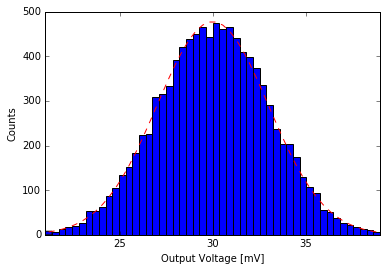

In [17]:
# our funtion takes the fit parameters and the points we 
# give it and returns the associated model values
def gaus_for_fit(mean, std, scale, a_x_values):
    return scale*scipy.stats.norm.pdf(a_x_values, mean, std)

# let's get out bin centers for the eventual fit
a_pmt_bin_centers = np.zeros(num_bins_pmt)
bin_width = bin_edges_pmt[1]-bin_edges_pmt[0]
for i in xrange(num_bins_pmt):
    a_pmt_bin_centers[i] = (bin_edges_pmt[i]+bin_edges_pmt[i+1])/2.

# plot using the true values to check if we're on the right track
_ = plt.hist(a_pmt_data, bins=num_bins_pmt, range=(lb_range_pmt, ub_range_pmt))
_ = plt.plot(a_pmt_bin_centers, gaus_for_fit(true_mean, true_std, np.sum(a_counts)*bin_width, a_pmt_bin_centers), 'r--')
_ = plt.xlim((lb_range_pmt, ub_range_pmt))
_ = plt.xlabel('Output Voltage [mV]')
_ = plt.ylabel('Counts')

So as expected, our true mean and standard deviation give us quite a good fit!  Notice that our scale was, as expected, related to the number of data points we have multiplied by the bin width.

So now we need to fit so let's create our log-likelihood function.

Remember, we are using the model to predict the **mean** of the Poisson distribution that describes a given bin.  This means that our likelihood function will be as follows:

$$\mathcal{L} = \prod_{i=1}^m \frac{f_i^{d_i} e^{-f_i}}{d_i!}$$

In this expression, m is the number of bins, $f_i$ is the function prediction of the mean for the ith bin, and $d_i$ is the number of data points in a given bin.  Intuitively, this is just saying that the further away the data points are for the mean, the less likely that the parameters used describe the true process.

Of course, this expression is a mess, so we fall back on our handy logarithm function to make this bearable!

$$ln(\mathcal{L}) = \sum_{i=1}^m (  d_i ln(f_i) - f_i - ( d_i ln(d_i) - d_i )  )$$

So let's write our log likelihood function and use a scipy's optimize library to find the maximum of it.  Note that we still want to find the maximum log likelihood but most software packages only give you a minimizer.  This is not a problem - we can just negate the log likelihood and find the minimum of this expression!

In [18]:
def neg_ln_likelihood_poisson(a_pars, a_bin_centers, a_counts):
    scale, mean, std = a_pars
    a_predicted_means = gaus_for_fit(scale, mean, std, a_bin_centers)
    return -np.sum( a_counts*np.log(a_predicted_means) - a_predicted_means - (a_counts*np.log(a_counts) - a_counts) )

results = scipy.optimize.minimize(neg_ln_likelihood_poisson, [true_mean, true_std, np.sum(a_counts)*bin_width], 
                                  args=(a_pmt_bin_centers, a_counts))

print 'Best fit parameters: %.2f, %.2f, %.2f' % (results.x[0], results.x[1], results.x[2])
print 'True values: %.2f, %.2f, %.2f' % (true_mean, true_std, np.sum(a_counts)*bin_width)

Best fit parameters: 30.02, 3.01, 3600.45
True values: 30.00, 3.00, 3590.64


Not bad, right??

## __Gaussian Approximation__

So we've seen that the Poisson approximation is quite good so let's try taking it a step further.  Remember in the limit of a large mean that a Poisson distribution can be approximated by a gaussian distribution.  So let's change our likelihood function such that each bin is given by a gaussian distribution.

$$\mathcal{L} = \prod_{i=1}^m \frac{1}{\sqrt{2 \pi f_i}} e^{-\frac{(f_i - d_i)^2}{2 f_i}}$$

And as usual, we use the log to make this computationally tractable.

$$ln(\mathcal{L}) = \sum_{i=1}^m (  -\frac{1}{2} ln(2 \pi f_i) - \frac{(f_i - d_i)^2}{2 f_i}  )$$

So now let's write out our new likelihood function and find the best fit parameters!

In [19]:
def neg_ln_likelihood_gaussain(a_pars, a_bin_centers, a_counts):
    scale, mean, std = a_pars
    a_predicted_means = gaus_for_fit(scale, mean, std, a_bin_centers)
    return -np.sum( -0.5*np.log(2*np.pi*a_predicted_means) - (a_predicted_means - a_counts)**2/(2*a_predicted_means) )

results = scipy.optimize.minimize(neg_ln_likelihood_gaussain, [true_mean, true_std, np.sum(a_counts)*bin_width], 
                                  args=(a_pmt_bin_centers, a_counts))

print 'Best fit parameters: %.2f, %.2f, %.2f' % (results.x[0], results.x[1], results.x[2])
print 'True values: %.2f, %.2f, %.2f' % (true_mean, true_std, np.sum(a_counts)*bin_width)

Best fit parameters: 30.02, 3.00, 3596.58
True values: 30.00, 3.00, 3590.64


Again, a great fit!

## __$\chi^2$ Approximation__

The famous $\chi^2$ fit.

The $\chi^2$ fit involves a slight switch in philosophy.  Instead of the model under test being our mean for the Poisson distribution, we will take our data to represent our mean.  For most simple applications, this switch is totally meaningless but it does suffer from some drawbacks (see questions).  This means our log likelihood function will change a little bit.

$$ln(\mathcal{L}) = \sum_{i=1}^m (  -\frac{1}{2} ln(2 \pi d_i) - \frac{(f_i - d_i)^2}{2 d_i}  )$$

Notice that the first term in the sum is now totally irrelevant - it is completely independent of the parameters we are trying to fit!  This means we can simply drop it.  Once we drop this term and negate the function, we are left with what we call the $\chi^2$ value.

$$\chi^2 = \sum_{i=1}^m (  \frac{(f_i - d_i)^2}{2 d_i}  )$$

When fitting, we try to **minimize** the $\chi^2$.

In [20]:
def neg_ln_likelihood_chi2(a_pars, a_bin_centers, a_counts):
    scale, mean, std = a_pars
    a_predicted_means = gaus_for_fit(scale, mean, std, a_bin_centers)
    return np.sum( (a_predicted_means - a_counts)**2/(2*a_counts) )

results = scipy.optimize.minimize(neg_ln_likelihood_chi2, [true_mean, true_std, np.sum(a_counts)*bin_width], 
                                  args=(a_pmt_bin_centers, a_counts))

print 'Best fit parameters: %.2f, %.2f, %.2f' % (results.x[0], results.x[1], results.x[2])
print 'True values: %.2f, %.2f, %.2f' % (true_mean, true_std, np.sum(a_counts)*bin_width)

Best fit parameters: 30.02, 3.00, 3589.99
True values: 30.00, 3.00, 3590.64


# __Questions__

1.  Can you think of a reason why taking the mean of the bin's distribution to be from data could be problematic (HINT: think about what happens in an empty bin)?
2.  Does the gaussian approximation truly make sense?  Where does it fail and why?